In [2]:
import symforce

symforce.set_symbolic_api("sympy")

import symforce.symbolic as sf
from symforce.notebook_util import display
from symforce import geo
from symforce import values
from symforce.geo.unsupported.pose3_se3 import Pose3_SE3

def n_link_forward_kinematics(joint_angles: values.Values, screw_axes_params: values.Values, M_params: values.Values, epsilon: sf.Scalar):
    """
    Computes the forward kinematics for an n-link robot using the Product of Exponentials (PoE) formula,
    with symbolic parameters for joint angles, screw axes, and the initial transformation.

    Args:
        joint_angles: A Values object containing symbolic joint angles, with keys "q1", "q2", etc.
        screw_axes_params: A Values object containing symbolic parameters for the screw axes.
                         Each key should be of the form "S{i}", where i is the joint index,
                         and the value should be a 6-vector representing the screw axis [omega_x, omega_y, omega_z, v_x, v_y, v_z].
        M_params: A Values object containing symbolic parameters for the initial transformation matrix M.
                  The keys should be "R" for the rotation (as a 3-vector Euler angles) and "t" for the translation (as a 3-vector).
        epsilon: A small number to handle singularities in Rot3.from_tangent.

    Returns:
        The homogeneous transformation matrix representing the end-effector configuration in the space frame.
    """
    # Construct the initial transformation matrix M from symbolic parameters
    R = geo.Rot3.from_yaw_pitch_roll(*M_params["R"])
    t = geo.V3(M_params["t"])
    M = geo.Pose3(R=R, t=t)

    # Initialize the transformation with M
    T = M

    n = len(joint_angles)

    # Compute the product of exponentials in reverse order
    for i in range(n, 0, -1):  # Start from n and go down to 1
        # Extract screw axis parameters and joint angle from Values objects
        S = screw_axes_params[f"S{i}"]
        q = joint_angles[f"q{i}"]

        # Create se3 element (6x1 vector)
        se3_element = sf.Matrix61(S * q)

        # Create a Pose3_SE3 object from the se3 element
        pose3_se3 = Pose3_SE3.from_tangent(se3_element, epsilon=epsilon)

        # Convert Pose3_SE3 to Pose3
        pose3 = sf.Pose3(R=pose3_se3.R, t=pose3_se3.t)

        # Update the transformation (multiply from the left)
        T = pose3 * T

    # Convert to homogeneous matrix at the end
    return T.to_homogenous_matrix()


# Example usage (adjust as needed for your specific case)
joint_angles = values.Values(
    q1=sf.Symbol("q1"),
    q2=sf.Symbol("q2"),
    q3=sf.Symbol("q3"),
)

screw_axes_params = values.Values(
    S1=sf.V6.symbolic("S1"),
    S2=sf.V6.symbolic("S2"),
    S3=sf.V6.symbolic("S3"),
)

M_params = values.Values(
    R=sf.V3.symbolic("R"),
    t=sf.V3.symbolic("t"),
)

epsilon = sf.numeric_epsilon
end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)

# display("End-Effector Pose:\n")
# display(f"{end_effector_pose}")

## Cleaning Small values applied by epsilon

In [3]:
import sympy as sp
from sympy import sympify, maple_code, Symbol

def remove_small_values(expr, threshold=1e-10):
    if isinstance(expr, sp.Number):
        return sp.Float(0) if abs(expr) < threshold else expr
    elif isinstance(expr, sp.Add):
        return sp.Add(*[remove_small_values(arg, threshold) for arg in expr.args])
    elif isinstance(expr, sp.Mul):
        cleaned_args = [remove_small_values(arg, threshold) for arg in expr.args]
        if any(arg == 0 for arg in cleaned_args):
            return sp.Float(0)
        return sp.Mul(*cleaned_args)
    elif isinstance(expr, sp.Pow):
        base = remove_small_values(expr.base, threshold)
        exp = remove_small_values(expr.exp, threshold)
        if exp == 0.5:  # This is a square root
            if isinstance(base, sp.Add):
                significant_terms = [term for term in base.args if not (isinstance(term, sp.Number) and abs(term) < threshold)]
                if len(significant_terms) == 0:
                    return sp.Float(0)
                elif len(significant_terms) == 1:
                    return sp.sqrt(significant_terms[0])
                else:
                    return sp.sqrt(sp.Add(*significant_terms))
            return sp.sqrt(base)
        return base ** exp
    elif isinstance(expr, (sp.sin, sp.cos, sp.tan)):
        return expr.func(remove_small_values(expr.args[0], threshold))
    else:
        return expr

def clean_expression(expr):
    cleaned_expr = remove_small_values(expr)
    return sp.simplify(cleaned_expr)


- `q1`: Output joint angle (revolute)
- `q3`: Input prismatic joint displacement
- `params`: A Values object containing geometric parameters of the mechanism
- `epsilon`: A small number to handle singularities

## Internal Kinematic Chains

The function defines two internal kinematic chains:

1. `chain1(q1)`: Represents the first part of the mechanism, from the base to the end of the first link.
2. `chain2(q2, q3)`: Represents the second part of the mechanism, including the prismatic joint.

These chains use the `n_link_forward_kinematics` function to compute their transformations.

## Loop Closure Condition

The `loop_closure(q1, q2, q3)` function enforces the constraint that both kinematic chains must meet at the same point, forming a closed loop.

## Solving for q1

The function solves for q1 in terms of q3 using the loop closure equations:

1. It sets up symbolic variables for q1, q2, and q3.
2. It applies the loop closure condition and cleans the resulting equations.
3. It uses `sf.solve()` to solve the equations for q1.
4. It extracts all solutions for q1 in terms of q3.

## Computing End-Effector Poses

For each solution of q1, the function computes the corresponding end-effector pose using `chain1`.

## Return Values

The function returns:
1. A list of end-effector poses (`T_sb_list`) for each solution of q1.
2. A dictionary containing:
   - 'q1': List of solutions for q1 in terms of q3
   - 'q3': The original q3 symbol

This function allows for a comprehensive analysis of the slider-crank mechanism's kinematics, providing multiple solutions when they exist and expressing the output joint angle in terms of the input displacement.

'End-Effector Poses:'

'Solution 1:'

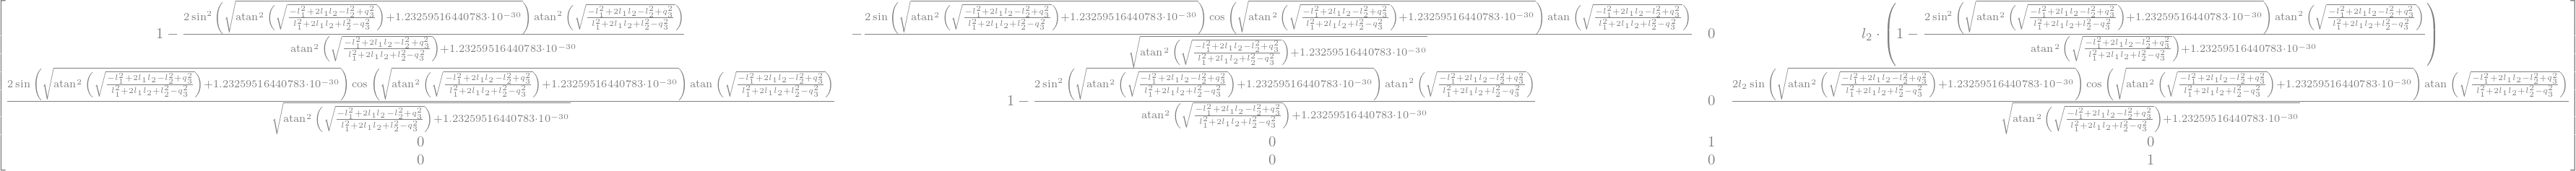

'\n'

'Solution 2:'

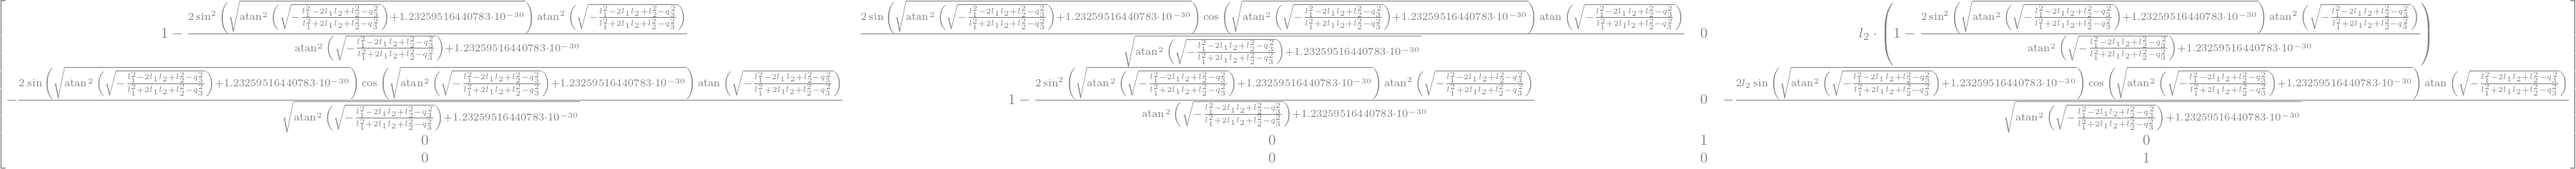

'\n'

'Joint Variables:'

'q1 solutions (in terms of q3):'

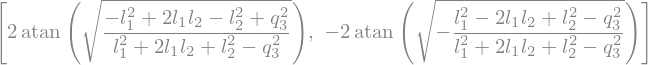

'q3:'

In [4]:

def eliminate_variable(eq1, eq2, var_to_eliminate):
    # Rearrange equations to isolate the variable to eliminate
    eq1_isolated = sf.solve(eq1, var_to_eliminate)[0]
    
    # Substitute the isolated variable into the second equation
    result = eq2.subs(var_to_eliminate, eq1_isolated)
    
    # Simplify the result
    return sf.simplify(result)

def slider_crank_kinematics(q1: sf.Scalar, q3: sf.Scalar, params: values.Values, epsilon: sf.Scalar):
    """
    Computes the forward kinematics for a slider-crank linkage (1-RRPR) using n_link_forward_kinematics.

    Args:
        q1: Output joint angle (revolute)
        q3: Input prismatic joint displacement
        params: A Values object containing geometric parameters of the mechanism
        epsilon: A small number to handle singularities

    Returns:
        A tuple (T_sb, joint_variables) where T_sb is the end-effector pose and
        joint_variables is a dictionary of all joint variables.
    """
    # Define the kinematic chains using n_link_forward_kinematics
    def chain1(q1):
        joint_angles = values.Values()
        joint_angles['q1'] = q1
        screw_axes = values.Values()
        screw_axes['S1'] = sf.V6([0, 0, 1, 0, 0, 0])
        # screw_axes['S2'] = sf.V6([0, 0, 1, -params['l1'], 0, 0])
        M = values.Values()
        M['R'] = sf.V3([0, 0, 0])
        M['t'] = sf.V3([params['l2'], 0, 0])
        return n_link_forward_kinematics(joint_angles, screw_axes, M, epsilon)
    
    def chain2(q2,q3):
        joint_angles = values.Values()
        joint_angles['q1'] = q2
        joint_angles['q2'] = q3-params['q3_min']
        # axis of rotation for revolute joint1
        omega1 = sf.V3(0, 0, 1)
        # Calculate v for revolute joint 1
        q1 = sf.V3(params['l1'], 0, 0)  # Point on the axis of joint 1
        v1 = -omega1.cross(q1)
        screw_axes = values.Values()
        screw_axes['S1'] = sf.V6(omega1.to_flat_list() + v1.to_flat_list())
        screw_axes['S2'] = sf.V6([0, 0, 0, 1, 0, 0])
        M = values.Values()
        M['R'] = sf.V3([0, 0, 0])
        M['t'] = sf.V3([params['l1']+params['q3_min'], 0, 0])
        return n_link_forward_kinematics(joint_angles, screw_axes, M, epsilon)
    
    # Loop-closure condition
    def loop_closure(q1,q2,q3):
        T1 = chain1(q1)
        T2 = chain2(q2, q3)
        # Extract the position vectors from the transformation matrices
        p1 = T1[0:3, 3]
        p2 = T2[0:3, 3]
        # The loop closure condition is that these positions should be equal
        return p1 - p2

    # Solve for q1 in terms of q3 using loop-closure condition
    q1 = sf.Symbol('q1', positive=True)
    q2 = sf.Symbol('q2', positive=True)
    q3 = sf.Symbol('q3', positive=True)
    closure_eqs = loop_closure(q1, q2, q3)
    # Apply clean_expression to each element of closure_eqs
    cleaned_closure_eqs = [sf.simplify(sf.expand(clean_expression(eq))) for eq in closure_eqs]    

    # Solve for q1 in terms of q3
    solution = sf.solve(cleaned_closure_eqs, q1)

    result=eliminate_variable(cleaned_closure_eqs[0], cleaned_closure_eqs[1], q2)
    
    q1_solutions=sf.solve(result, q1)
    # Extract all solutions for q1 in terms of q3

    q1_solution = [sol for sol in q1_solutions]  # Extract the expression from each tuple

    # Compute final end-effector poses for all solutions
    T_sb_list = [chain1(q1_sol) for q1_sol in q1_solution]

    return T_sb_list, {'q1': q1_solutions, 'q3': q3}

# Example usage
params = values.Values()
params['q3_min']=sf.Symbol('q3_min',positive=True)
params['l1'] = sf.Symbol('l1',positive=True)
params['l2'] = sf.Symbol('l2',positive=True)
q1 = sf.Symbol('q1',positive=True)
q3 = sf.Symbol('q3',positive=True)
epsilon = sf.numeric_epsilon

T_sb_list, joint_fk_vars = slider_crank_kinematics(q1, q3, params, epsilon)



display("End-Effector Poses:")
for i, T_sb in enumerate(T_sb_list):
    display(f"Solution {i+1}:")
    display(T_sb)
    display("\n")

display("Joint Variables:")
display("q1 solutions (in terms of q3):")
display(joint_fk_vars['q1'])
display("q3:")
display(joint_fk_vars['q3'])

# Inverse Kinematics

'Inverse Kinematics Solutions:'

'q3 solutions (in terms of q1):'

'Solution 1:'

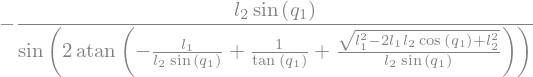

'\n'

'Solution 2:'

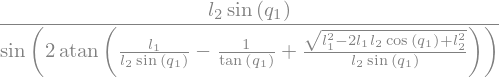

'\n'

'Joint Variables:'

'q1:'

In [5]:
def slider_crank_inverse_kinematics(q1: sf.Scalar, params: values.Values, epsilon: sf.Scalar):
    """
    Computes the inverse kinematics for a slider-crank linkage (1-RRPR) using n_link_forward_kinematics.

    Args:
        q1: Input joint angle (revolute)
        params: A Values object containing geometric parameters of the mechanism
        epsilon: A small number to handle singularities

    Returns:
        A tuple (q3_solutions, joint_variables) where q3_solutions is a list of solutions for q3
        and joint_variables is a dictionary of all joint variables.
    """
    # Define the kinematic chains using n_link_forward_kinematics
    def chain1(q1):
        joint_angles = values.Values()
        joint_angles['q1'] = q1
        screw_axes = values.Values()
        screw_axes['S1'] = sf.V6([0, 0, 1, 0, 0, 0])
        # screw_axes['S2'] = sf.V6([0, 0, 1, -params['l1'], 0, 0])
        M = values.Values()
        M['R'] = sf.V3([0, 0, 0])
        M['t'] = sf.V3([params['l2'], 0, 0])
        return n_link_forward_kinematics(joint_angles, screw_axes, M, epsilon)
    
    def chain2(q2,q3):
        joint_angles = values.Values()
        joint_angles['q1'] = q2
        joint_angles['q2'] = q3-params['q3_min']
        # axis of rotation for revolute joint1
        omega1 = sf.V3(0, 0, 1)
        # Calculate v for revolute joint 1
        q1 = sf.V3(params['l1'], 0, 0)  # Point on the axis of joint 1
        v1 = -omega1.cross(q1)
        screw_axes = values.Values()
        screw_axes['S1'] = sf.V6(omega1.to_flat_list() + v1.to_flat_list())
        screw_axes['S2'] = sf.V6([0, 0, 0, 1, 0, 0])
        M = values.Values()
        M['R'] = sf.V3([0, 0, 0])
        M['t'] = sf.V3([params['l1']+params['q3_min'], 0, 0])
        return n_link_forward_kinematics(joint_angles, screw_axes, M, epsilon)
    
        # Loop-closure condition
    def loop_closure(q1,q2,q3):
        T1 = chain1(q1)
        T2 = chain2(q2, q3)
        # Extract the position vectors from the transformation matrices
        p1 = T1[0:3, 3]
        p2 = T2[0:3, 3]
        # The loop closure condition is that these positions should be equal
        return p1 - p2

    # Solve for q3 in terms of q1 using loop-closure condition
    q1 = sf.Symbol('q1', positive=True)
    q2 = sf.Symbol('q2', positive=True)
    q3 = sf.Symbol('q3', positive=True)
    closure_eqs = loop_closure(q1, q2, q3)
    cleaned_closure_eqs = [sf.simplify(sf.expand(clean_expression(eq))) for eq in closure_eqs]    

    # Solve for q3 in terms of q1
    solution = sf.solve(cleaned_closure_eqs, [q3,q2])

    # Extract all solutions for q3 in terms of q1
    q3_solutions = [sol[0] for sol in solution]

    return q3_solutions, {'q1': q1, 'q3': q3_solutions}

# Example usage
params = values.Values()
params['q3_min'] = sf.Symbol('q3_min', positive=True)
params['l1'] = sf.Symbol('l1', positive=True)
params['l2'] = sf.Symbol('l2', positive=True)
q1 = sf.Symbol('q1', positive=True)
epsilon = sf.numeric_epsilon

q3_solutions, joint_ik_vars = slider_crank_inverse_kinematics(q1, params, epsilon)

display("Inverse Kinematics Solutions:")
display("q3 solutions (in terms of q1):")
for i, sol in enumerate(q3_solutions):
    display(f"Solution {i+1}:")
    display(sol)
    display("\n")

display("Joint Variables:")
display("q1:")
display(joint_ik_vars['q1'])

# Jacobian Analysis

'Solution 1:'

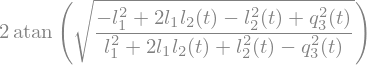

'Solution 2:'

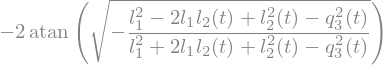

'Jacobian for the first solution:'

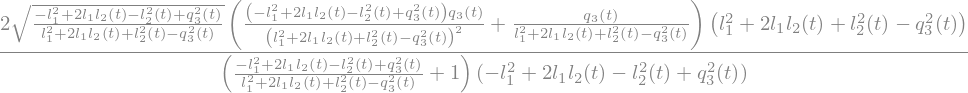

'Jacobian for the second solution:'

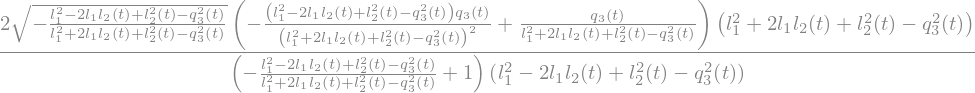

'Maximum q̇1 for the first solution:'

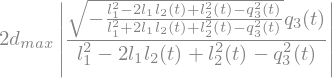

'Maximum q̇1 for the second solution:'

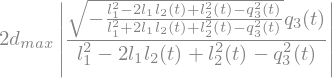

In [6]:
import symforce.symbolic as sf
from symforce.notebook_util import display

# Assuming joint_fk_vars is already defined from the forward kinematics solution
# joint_fk_vars = {'q1': [solution1, solution2], 'q3': q3}

# Define time symbol
t = sf.Symbol('t')

# Define variables as functions of time
q1_t = sf.Function('q1')(t)
q2_t = sf.Function('q2')(t)
q3_t = sf.Function('q3')(t)
l2_t = sf.Function('l2')(t)

# Define maximum actuator velocity
d_max = sf.Symbol('d_max')

# Use the existing solutions from joint_fk_vars and make q3, q2, and l2 functions of time
q1_solutions = joint_fk_vars['q1']

# Create a dictionary for substitutions
subs_dict = {
    joint_fk_vars['q3']: q3_t,
    sf.Symbol('q2',positive=True): q2_t,
    sf.Symbol('l2',positive=True): l2_t
}

# Replace q3, q2, and l2 with their time-dependent versions in the solutions
q1_sol1 = q1_solutions[0].subs(subs_dict)
q1_sol2 = q1_solutions[1].subs(subs_dict)

display("Solution 1:")
display(q1_sol1)
display("Solution 2:")
display(q1_sol2)

# Calculate the Jacobians (dq1/dq3)
jacobian1 = sf.diff(q1_sol1, q3_t)
jacobian2 = sf.diff(q1_sol2, q3_t)

display("Jacobian for the first solution:")
display(jacobian1)
display("Jacobian for the second solution:")
display(jacobian2)

# # Calculate the Jacobians (dq1/dq3)
# jacobian1 = sf.diff(joint_fk_vars['q1'][0], q3_t)
# jacobian2 = sf.diff(joint_fk_vars['q1'][1], q3_t)

# Calculate q̇1max for both solutions
q1_dot_max1 = sf.Abs(jacobian1) * d_max
q1_dot_max2 = sf.Abs(jacobian2) * d_max

display("Maximum q̇1 for the first solution:")
display(sf.simplify(sf.expand(q1_dot_max1)))
display("Maximum q̇1 for the second solution:")
display(sf.simplify(sf.expand(q1_dot_max2)))

# Singularity Analysis of Slider-Crank Mechanism

## Overview

This analysis examines the singular configurations of a slider-crank mechanism, focusing on the prismatic joint displacement (q3). We investigate two Jacobians corresponding to different solutions or aspects of the mechanism's kinematics.


considering the follwing equation
τ = f / J
in order for the mechanism to correctly trasfer power to the joints the J should be definitive and non zero


## Key Components

- **q1**: Crank angle
- **q3**: Prismatic joint displacement
- **l1**: Length of the crank
- **l2**: Length of the connecting rod
- **q3_min**: Minimum value of q3

## Analysis Method

We analyze singularities by examining the numerator and denominator of each Jacobian separately. The analysis includes:

1. Finding configurations where the denominator is zero
2. Finding configurations where the numerator is zero
3. Identifying removable singularities (where both numerator and denominator are zero)
4. Verifying known singular configurations

## Interpretation of Results

### Denominator Zero Singularities

These represent configurations where:
- The mechanism may lose a degree of freedom
- An infinitesimal input may produce a large output
- The mechanism may gain an instantaneous degree of freedom

### Numerator Zero Singularities

These represent configurations where:
- Input motion may not produce output motion (or vice versa)
- The mechanism may lose its ability to transmit force/motion in a particular direction

### Removable Singularities

While mathematically interesting, these may not always have distinct practical implications in mechanism analysis. They represent special cases where both the numerator and denominator are zero simultaneously.

### Known Singularities

1. **Fully Extended**: When q3 = l1 + l2
   - The mechanism is at its maximum extension
   - May correspond to a change in the mechanism's behavior

2. **Folded**: When q3 = |l1 - l2|
   - The mechanism is at its minimum extension
   - May correspond to another critical configuration

## Practical Implications

1. **Control Strategies**: Avoid or carefully manage motion near singular configurations.
2. **Workspace Analysis**: Understand the limitations and characteristics of the mechanism's workspace.
3. **Force Transmission**: Be aware of configurations where force transmission may be compromised or amplified.
4. **Mechanism Design**: Consider modifying design parameters to minimize problematic singularities within the desired workspace.

## Limitations and Considerations

- Some mathematically identified singularities may not be physically realizable.
- The analysis assumes ideal conditions and doesn't account for factors like friction or component flexibility.
- The practical significance of each singularity type may vary based on the specific application of the mechanism.


In [10]:
jacobian1=sf.simplify(jacobian1)
jacobian2=sf.simplify(jacobian2)

def get_numer_denom(expr):
    """
    Get the numerator and denominator of a symbolic expression.
    
    Args:
    expr: A SymForce symbolic expression
    
    Returns:
    A tuple (numerator, denominator)
    """
    return expr.as_numer_denom()

'Singular configurations for Jacobian 1:'

'Denominator zero:'

'q3 ='

'q3 ='

'Numerator zero:'

'q3 ='

'q3 ='

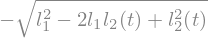

'q3 ='

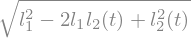

'Singular configurations for Jacobian 2:'

'Denominator zero:'

'q3 ='

'q3 ='

'Numerator zero:'

'q3 ='

'q3 ='

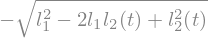

'q3 ='

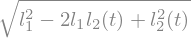

'Removable singularities for Jacobian 1:'

'q3 ='

'q3 ='

'Removable singularities for Jacobian 2:'

'q3 ='

'q3 ='

'Verifying known singularities:'

'Fully extended condition:'

'q3 ='

'Folded condition:'

'q3 ='

In [34]:
jacob_numerator1, jacob_denominator1 = get_numer_denom(jacobian1)
jacob_numerator2, jacob_denominator2 = get_numer_denom(jacobian2)

#To fully avoid singularities, we need both conditions to be true simultaneously:
#jacob_denominator1 ≠ 0 AND jacob_numerator1 ≠ 0

# Define time symbol
t = sf.Symbol('t')

# Define variables as functions of time
q1_t = sf.Function('q1')(t)
q2_t = sf.Function('q2')(t)
q3_t = sf.Function('q3')(t)
l2_t = sf.Function('l2')(t)
# Define symbolic variables
l1 = sf.Symbol('l1')
q3_min = sf.Symbol('q3_min')

def find_singularities(numerator, denominator):
    """
    Find symbolic conditions for singularities, considering both numerator and denominator.
    Only solves for q3.
    """
    # Solve denominator = 0
    den_singularities = sf.solve(denominator, q3_t)
    
    # Solve numerator = 0
    num_singularities = sf.solve(numerator, q3_t)
    
    return {
        'denominator_zero': den_singularities,
        'numerator_zero': num_singularities
    }

def removable_singularities(numerator, denominator):
    """
    Find removable singularities where both numerator and denominator are zero.
    """
    return sf.solve([numerator, denominator], q3_t)

# Find singularities for both Jacobians
singularities1 = find_singularities(jacob_numerator1, jacob_denominator1)
singularities2 = find_singularities(jacob_numerator2, jacob_denominator2)

# Find removable singularities
removable1 = removable_singularities(jacob_numerator1, jacob_denominator1)
removable2 = removable_singularities(jacob_numerator2, jacob_denominator2)

display("Singular configurations for Jacobian 1:")
display("Denominator zero:")
for sol in singularities1['denominator_zero']:
    display("q3 =")
    display(sol)

display("Numerator zero:")
for sol in singularities1['numerator_zero']:
    display("q3 =")
    display(sol)

display("Singular configurations for Jacobian 2:")
display("Denominator zero:")
for sol in singularities2['denominator_zero']:
    display("q3 =")
    display(sol)

display("Numerator zero:")
for sol in singularities2['numerator_zero']:
    display("q3 =")
    display(sol)

display("Removable singularities for Jacobian 1:")
for sol in removable1:
    display("q3 =")
    display(sol)

display("Removable singularities for Jacobian 2:")
for sol in removable2:
    display("q3 =")
    display(sol)

# Verify known singularities symbolically
fully_extended = sf.solve(q3 - (l1 + l2_t), q3)
folded = sf.solve(q3 - sf.Abs(l1 - l2_t), q3)

display("Verifying known singularities:")
display("Fully extended condition:")
for sol in fully_extended:
    display("q3 =")
    display(sol)

display("Folded condition:")
for sol in folded:
    display("q3 =")
    display(sol)